In [1]:
import pandas as pd
import os
import logging
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix



In [2]:
class DataAquisition():

    def __init__(self, path, sep=None, decimal=None):
        self.df = pd.read_csv(path, sep=sep, decimal=decimal)
        

In [3]:
class DataPreparation():

    def __init__(self, data):
        self.data = data

    def data_subset(self, subset):
        try:
            self.df = self.data[subset]
            return self.df
            
        except Exception as e:
            msg = f"Error to prepare the subset: {type(e)}, {str(e)}"
            logging.error(msg, exc_info=True)

    def drop_nan(self, axis=None, how=None):
        try:
            df = self.data.dropna(axis=axis, how=how)
            return df

        except Exception as e:
            msg = f"Error to remove NAN: {type(e)}, {str(e)}"
            logging.error(msg, exc_info=True)

    def remove_outlier(self, subset, n_std=3):
        try:
            for col in subset[:-1]:
                mean_value = self.data[col].mean()
                sd = self.data[col].std()
                df = self.data[(self.data[col] <= mean_value + (n_std * sd))]
            
            return df
        
        except Exception as e:
            msg = f"Error to remove outlier: {type(e)}, {str(e)}"
            logging.error(msg, exc_info=True)

    def smooth_data(self, subset, alpha, adjust=True):
        try:
            for col in subset[:-1]:
                self.data[col] = self.data[col].ewm(
                    alpha=alpha, adjust=adjust).mean()
            return self.data

        except Exception as e:
            msg = f"Error to smooth data: {type(e)}, {str(e)}"
            logging.error(msg, exc_info=True)

    

In [4]:
class Model():

    def __init__(self, data):
        self.data = data

    def data_split_train(self, variables, predictor, test_size=0.3, random_state=0):

        X = self.data[variables]
        y = self.data[predictor]

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size,
                                                            random_state=random_state,
                                                            stratify=y)

        data_split = {
            "X_train" : X_train,
            "X_test": X_test,
            "y_train": y_train,
            "y_test": y_test
        }

        return data_split

    def train_random_forest_classification(self, n_estimators=100, n_jobs=-1, random_state=0):
        model = RandomForestClassifier(n_estimators=n_estimators,
                                       random_state=random_state,
                                       n_jobs=n_jobs)
        model.fit(self.data["X_train"], self.data["y_train"])

        return model

    def model_y_pred(self, model):
        y_pred = model.predict(self.data["X_test"])

        return y_pred


    def model_accuracy_score(self, y_pred):
        model_accuracy = metrics.accuracy_score(self.data["y_test"], y_pred)

        return model_accuracy


    def model_feature_score(self, model):
        feature_scores = pd.Series(model.feature_importances_, 
                                   index=self.data["X_train"].columns).sort_values(ascending=False)
        return feature_scores

    def model_classification_report(self, y_pred):
        report = classification_report(self.data["y_test"], y_pred)
        print(report)

        return report

In [5]:
class GraphicalAnalysis():

    def feature_barplot(self, feature_score):
        sns.barplot(x=feature_score, y=feature_score.index)
        plt.xlabel("Feature Importance Score")
        plt.ylabel("Feature")
        plt.show()

    def feature_confusion_matrix(self, y_pred, data):
        cm = confusion_matrix(data["y_test"], y_pred, normalize="true")
        np.set_printoptions(precision=2)
        return cm

    def feature_heatmap(self, cm):
        sns.heatmap(cm, annot=True, fmt=".2f", cmap="YlGnBu")
        plt.show()

In [6]:
class SaveModel():

    def save_model(self, model):
        pickle.dump(model, open("/home/marcelo/Documents/CerradoPlantNutrition/model/model.pkl", "wb"))


## Main()

In [7]:
path = os.path.normpath("/home/marcelo/Documents/CerradoPlantNutrition/sample/cerrado_physionomies.csv")
    
#data aquisition
data_aq = DataAquisition(path, sep=",", decimal=".")
df = pd.DataFrame(data_aq.df)

In [8]:
#data preparation
subset = ["N(g kg-1)","P(g kg-1)","K(g kg-1)","Ca(g kg-1)","Mg(g kg-1)","Fe(mg kg-1)","Mn(mg kg-1)","Vegetation"]

data_subset = DataPreparation(df).data_subset(subset)

In [9]:
data_drop_nan = DataPreparation(data_subset).drop_nan(axis=0, how="any")

In [10]:
data_remove_outlier = DataPreparation(data_drop_nan).remove_outlier(subset, n_std=3)

In [11]:
data_smoothed = DataPreparation(data_remove_outlier).smooth_data(subset, alpha=0.5, adjust=True)


/tmp/ipykernel_10260/2656117650.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data[col] = self.data[col].ewm(


In [12]:
#spliting data
split_data = Model(data_smoothed).data_split_train(subset[:-1], subset[-1],
                                                         test_size=0.3, random_state=0)

In [13]:
#training model
train_model = Model(split_data).train_random_forest_classification(n_jobs=-1, random_state=0)


In [14]:
y_pred = Model(split_data).model_y_pred(train_model)

In [15]:
model_accuracy = Model(split_data).model_accuracy_score(y_pred)

print(model_accuracy)

0.9304347826086956


In [16]:
feature_score = Model(split_data).model_feature_score(train_model)

print(feature_score)

P(g kg-1)      0.245361
K(g kg-1)      0.219511
N(g kg-1)      0.214080
Mg(g kg-1)     0.136702
Ca(g kg-1)     0.117998
Fe(mg kg-1)    0.039611
Mn(mg kg-1)    0.026737
dtype: float64


In [17]:
classification_report = Model(split_data).model_classification_report(y_pred)

print(classification_report)

                    precision    recall  f1-score   support

          cerradao       0.50      0.29      0.36         7
           cerrado       0.80      0.67      0.73         6
              mata       1.00      1.00      1.00        48
mata_semi_descidua       0.91      0.98      0.95        54

          accuracy                           0.93       115
         macro avg       0.80      0.73      0.76       115
      weighted avg       0.92      0.93      0.92       115

                    precision    recall  f1-score   support

          cerradao       0.50      0.29      0.36         7
           cerrado       0.80      0.67      0.73         6
              mata       1.00      1.00      1.00        48
mata_semi_descidua       0.91      0.98      0.95        54

          accuracy                           0.93       115
         macro avg       0.80      0.73      0.76       115
      weighted avg       0.92      0.93      0.92       115



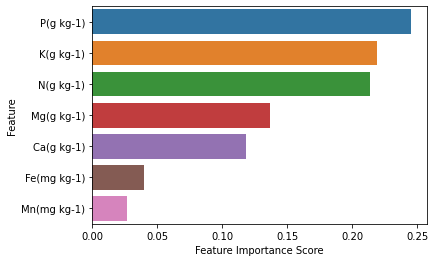

In [18]:
##Graphical analysis
GraphicalAnalysis().feature_barplot(feature_score)

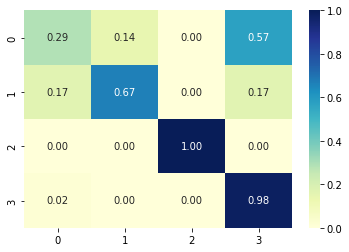

In [19]:
conf_matrix = GraphicalAnalysis().feature_confusion_matrix(y_pred, split_data)

GraphicalAnalysis().feature_heatmap(conf_matrix)

In [20]:
#saving the model
SaveModel().save_model(train_model)